In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

In [3]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

In [4]:
df_all = pd.DataFrame.from_dict(mek).fillna(0).sort_values(by=['high', 'med', 'low-t'], ascending=False).astype(int)
df_50p = df_all.loc[(df_all['high'] >= 50) & ((df_all['high']+df_all['med']) > 2*df_all['low-t'])]
df_20to50 = df_all.loc[(df_all['high'].isin(range(10,50))) & 
                       (df_all['high'] > df_all['med']) & 
                       ((df_all['high']+df_all['med']) > 5*df_all['low-t']) ]

In [5]:
df_pos = df_50p.append(df_20to50)
df_pos = df_pos.drop(['6L/7aL/9A/9a*', '6L/7aI/9A/9a*'])
pos = df_pos.to_dict()
df_pos.describe()

,high,med,low-t
count,32375.000000,32375.000000,32375.000000
mean,136.651459,11.120278,10.629900
std,89.495364,15.084619,8.146936
min,10.000000,0.000000,0.000000
25%,77.000000,0.000000,5.000000
50%,116.000000,3.000000,9.000000
75%,171.000000,18.000000,15.000000
max,1185.000000,162.000000,69.000000


Here, the filtering steps have been completed: the result is a dataset with 32,4K variants that we are confident to call active MEK1 variants. Next, I use these variants to explore the enrichment of different amino acids amongst positive variants.

## 1D enrichment pie charts and heat maps

In [6]:
from ipynb.fs.defs.Library_diversity import make_composition_plot_per_position, single_fraction_enrichment

In [7]:
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']
valid_pos = ['6', '7a', '8a', '9', '11', '13']

The first plot is special, and is used to set up later plots.

In [8]:
pos_e = single_fraction_enrichment(pos, 'high', 1, proportion=False) # all variants contribute equally
df_enr = pd.DataFrame.from_dict(pos_e).reindex(aa_order) # reindex to get a sensible colour scheme
df_enr

,6,7a,8a,9,11,13
A,1825,1374,15427,1389,1127,2256
G,2058,1411,0,922,920,1539
P,3412,3241,0,2297,1285,2313
Y,2185,1393,0,1625,1453,1666
D,972,606,0,1054,981,1586
K,2501,2209,0,1598,1144,1911
M,3015,1680,0,3403,2547,3203
V,2197,2154,0,1876,2600,3401
I,2496,5133,0,4886,6487,4360
L,4806,6866,0,7565,7870,3443


In [9]:
restrictions  = [[{'7a':['A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y'], '8a':['A']}, '7aX 8aA'],
                 [{'7a':['Δ'], '8a':['Δ']}, '7aΔ 8aΔ'],
                 [{'9':['L'], '11':['L']}, '9L 11L'],
                 [{'9':['I'], '11':['L']}, '9I 11L'],
                 [{'9':['L'], '11':['I']},'9L 11I'],
                 [{'9':['I'], '11':['I']}, '9I 11I'],
                 [{'9':['I', 'L'], '11':['I','L']},'9 I/L\n11 I/L'],
                 [{'9': ['A', 'D', 'F', 'G', 'K', 'M', 'P', 'V', 'W', 'Y'], 
                   '11':['A', 'D', 'F', 'G', 'K', 'M', 'P', 'V', 'W', 'Y']}, '9 no I/L\n11 no I/L']
                 ]

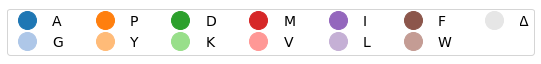

In [10]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
sns.set_palette(pal)

fig, ax = plt.subplots(1,1, figsize=(1,1))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
fig.legend(markers, aa_order, numpoints=1, loc='center left', ncol=7, markerscale=3, fontsize=14)
ax.axis('off')
plt.tight_layout()
#plt.savefig('Pie_legend.svg')
plt.show()

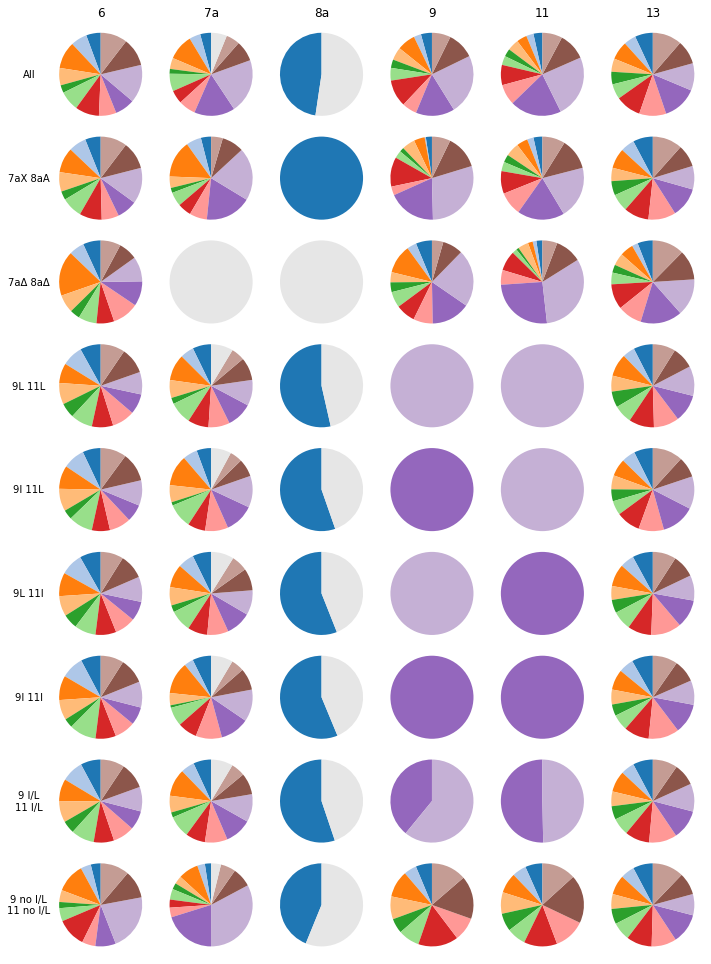

In [11]:
fig, axes = plt.subplots(len(restrictions)+1,6, 
                         figsize=(10,(len(restrictions)+1)*1.5),
                         gridspec_kw={'hspace': 0, 'wspace': 0})

# the first row is special and plots the unfiltered variants
row = 0
for i in range(len(valid_pos)):
    axes[row][i].set_title(valid_pos[i])
    axes[row][i].pie(df_enr[valid_pos[i]], startangle=90)
    if i == 0:
        axes[row][i].set_ylabel('All', rotation='horizontal', labelpad=20, va='center')

# then we loop over the restrictions
for row in range(1,len(restrictions) +1):
    cnts = single_fraction_enrichment(pos, 'high', 1, restrictions[row-1][0], proportion=False)
    df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
    for i in range(len(valid_pos)):
        axes[row][i].pie(df_restrict[valid_pos[i]], startangle=90)
        if i == 0:
            axes[row][i].set_ylabel(restrictions[row-1][1], rotation='horizontal', labelpad=20, va='center')

plt.tight_layout()
#plt.savefig('Pie_plots.svg')
plt.show()

### Generate arrays for 15 cross-position enrichments

In [12]:
from ipynb.fs.defs.Library_diversity import convert_variant_to_dict

In [13]:
# Set palette and the order of amino acids for meaningful colors
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

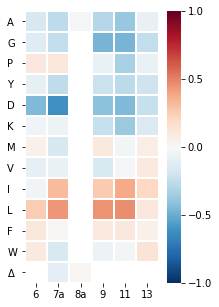

In [14]:
crange=[-1, 1]
fig, axes = plt.subplots(1,1, figsize=(3,5))

# the first row is special and plots the unfiltered variants
ax = axes
log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=1, ax=ax, cmap="RdBu_r", 
            cbar=True, cbar_kws={'ticks': [crange[0], crange[0]/2, 0, crange[1]/2, crange[1]]})
#ax.set_title('High binding - All curated sequences')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
ax.tick_params(axis='y', which='major', pad=14)

#plt.savefig('1D_heatmap_-1to1.svg')
plt.show()

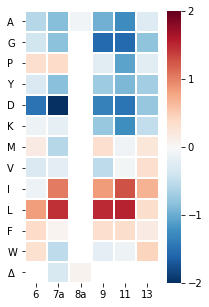

In [15]:
crange=[-2, 2]
fig, axes = plt.subplots(1,1, figsize=(3,5))

# the first row is special and plots the unfiltered variants
ax = axes
log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log2)   
sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=1, ax=ax, cmap="RdBu_r", 
            cbar=True, cbar_kws={'ticks': [crange[0], crange[0]/2, 0, crange[1]/2, crange[1]]})
#ax.set_title('High binding - All curated sequences')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
ax.tick_params(axis='y', which='major', pad=14)

plt.savefig('1D_heatmap_log2_-2to2.svg')
plt.show()

In [16]:
def two_position_joint_count(input, proportion=True):
    """
    input: a Counter 
    posA, posB: two positions between which to generate a heatmap
    """    
    counts = {
        posA : {
            aaA : {
                posB : {
                    aaB: 0 for aaB in pos_aa[posB]}
                for posB in valid_pos}
            for aaA in pos_aa[posA]}
        for posA in valid_pos}

    for mutation_string, count in input.items():
         # m_by_pos[position] = AA
        m_by_pos = convert_variant_to_dict(mutation_string)
        # check the mutations is one we're interested in
        observed_aa = set(m_by_pos.values())
        if not observed_aa.issubset(aa_13):
            continue
                
        if proportion:
            c = count
        else:
            c = 1
                
        # here this becomes similar as for single enrichments, except we need to loop twice
        for posA, aaA in m_by_pos.items():
            for posB, aaB in m_by_pos.items():
                counts[posA][aaA][posB][aaB] += c

    return counts

In [17]:
two_position_counts = two_position_joint_count(pos['high'])

In [18]:
joint_count_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {aaA : [two_position_counts[posA][aaA][posB][aaB] for aaB in pos_aa[posB]] for aaA in pos_aa[posA]}
        joint_count_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=pos_aa[posB])

In [19]:
joint_count_dfs['6']['8a']

,A,Δ
A,153917,158964
G,127802,136449
P,163891,212611
Y,144911,138228
D,80412,73039
K,160319,172108
M,163022,234244
V,149043,197093
I,125289,153676
L,287291,439754


The enrichment of variants compared to evenly distributed library: $log(\frac{freq_{xy}}{ideal_{xy}})$. 1D plot: $log(\frac{freq_{x}}{ideal_{x}})$

In [20]:
def get_joint_log_dfs(joint_count_dfs, log_function):

    log_freq_dfs = {}
    joint_freq_dfs = {}

    # make the dataframes
    for posA in valid_pos:
        log_freq_dfs[posA] = {}
        joint_freq_dfs[posA] = {}
        for posB in valid_pos:
            total = joint_count_dfs[posA][posB].sum().sum()
            cells = len(pos_aa[posA]) * len(pos_aa[posB])
            avg_cnt = total/cells

            joint_freq_dfs[posA][posB] = joint_count_dfs[posA][posB]/total
            log_freq_dfs[posA][posB] = (joint_count_dfs[posA][posB]/avg_cnt).apply(log_function)
            
    return joint_freq_dfs, log_freq_dfs

In [21]:
def cross_enrichment_plot(ax_lims, log_function=np.log10, fname=None):
    
    
    joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, log_function)

    fig, axes = plt.subplots(5, 5, figsize=(13,14),
                             gridspec_kw={'width_ratios': [2,2.2,0.4,2,2],'height_ratios': [2.2,0.4,2,2,2],
                                         'wspace':0.05, 'hspace':0.05})
    # figsize (width, height)
    # top left axes = axes[0,0]
    # top row, middle = axes[0,2]
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]

    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            sns.heatmap(log_freq_dfs[valid_pos[a]][valid_pos[b]], vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=ax, 
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes
            
            # draw a box, hide labels
            for sp in ax.spines.keys():
                ax.spines[sp].set_visible(True)
            # if we don't want any ticks or labels
            ax.tick_params(bottom=False,left=False, labelbottom=False, labelleft=False)

            # turn the labels back on at the outer edges
            if b == 0:
                ax.tick_params(left=True, labelleft=True)
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
                ax.tick_params(axis='y', which='major', pad=11)
            if a == 5:
                ax.tick_params(bottom=True, labelbottom=True)
                ax.set_xlabel(valid_pos[b])
            
    # colorbar formatting
    axes[0][2].axis('on')

#     # add the 1D plot in top right corner
#     ax = axes[0][1]
#     ax.axis('on')
#     log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(np.log10)   
#     sns.heatmap(log_enr, vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, cmap="RdBu_r", cbar=False)
#     ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
#     ax.tick_params(axis='y', which='major', pad=11)

    fig.align_labels()

    #plt.tight_layout()
    if fname:
        plt.savefig(fname, transparent=True)
    plt.show()

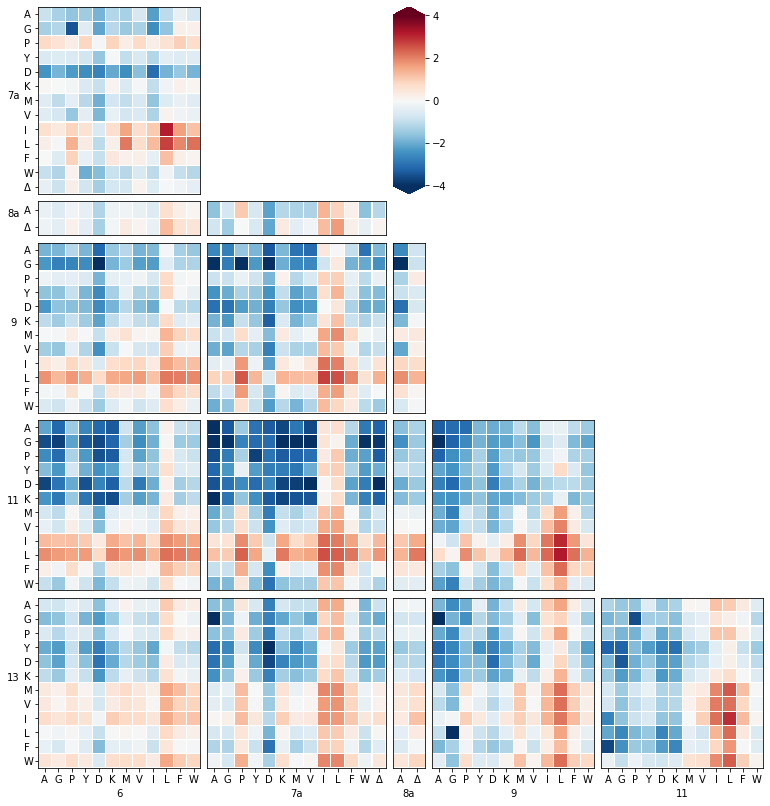

In [22]:
cross_enrichment_plot((-4,4), np.log2, 'Joint_enrichment_log2_-4to4.svg')

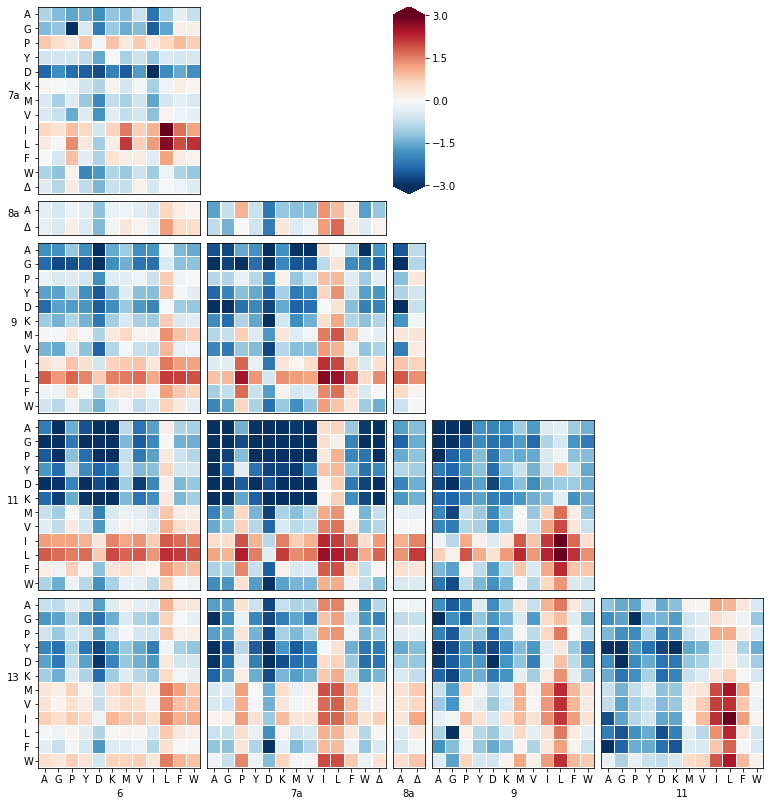

In [23]:
cross_enrichment_plot((-3,3), np.log2, 'Joint_enrichment_log2_-3to3.svg')

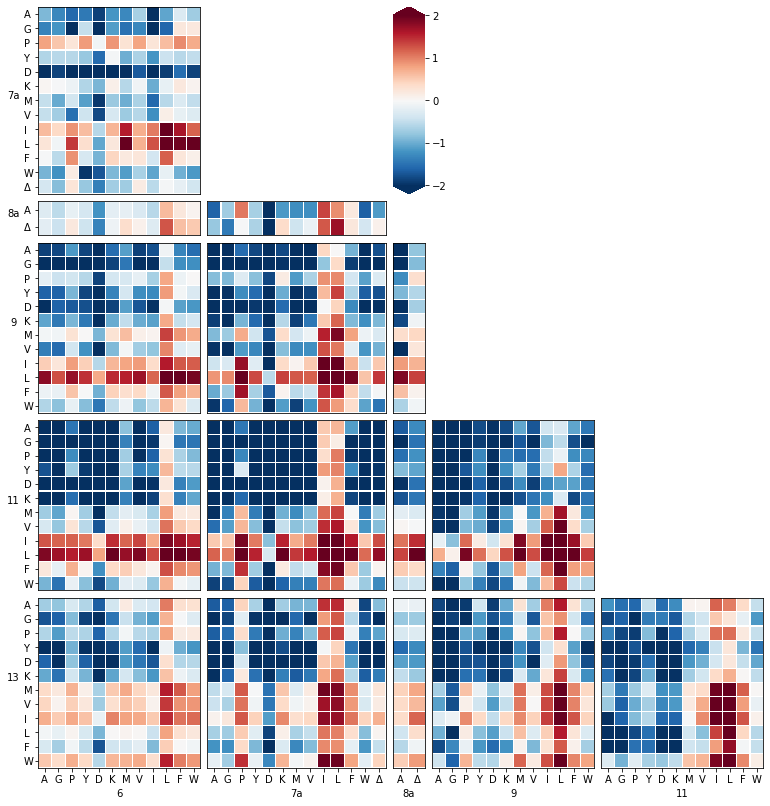

In [24]:
cross_enrichment_plot((-2,2), np.log2, 'Joint_enrichment_log2_-2to2.svg')

#### Conditional probability plots

need to disentangle that normalisation system

In [25]:
log_col_dfs = {}

for posA in valid_pos:
    log_col_dfs[posA] = {}
    for posB in valid_pos:
        top_df = joint_count_dfs[posA][posB] # the joint count of a, b co-occurrence
        bottom_df = joint_count_dfs[posA][posB].sum()/joint_count_dfs[posA][posB].astype(bool).sum(axis=0)
        log_col_dfs[posA][posB] = (top_df/bottom_df).apply(np.log2)

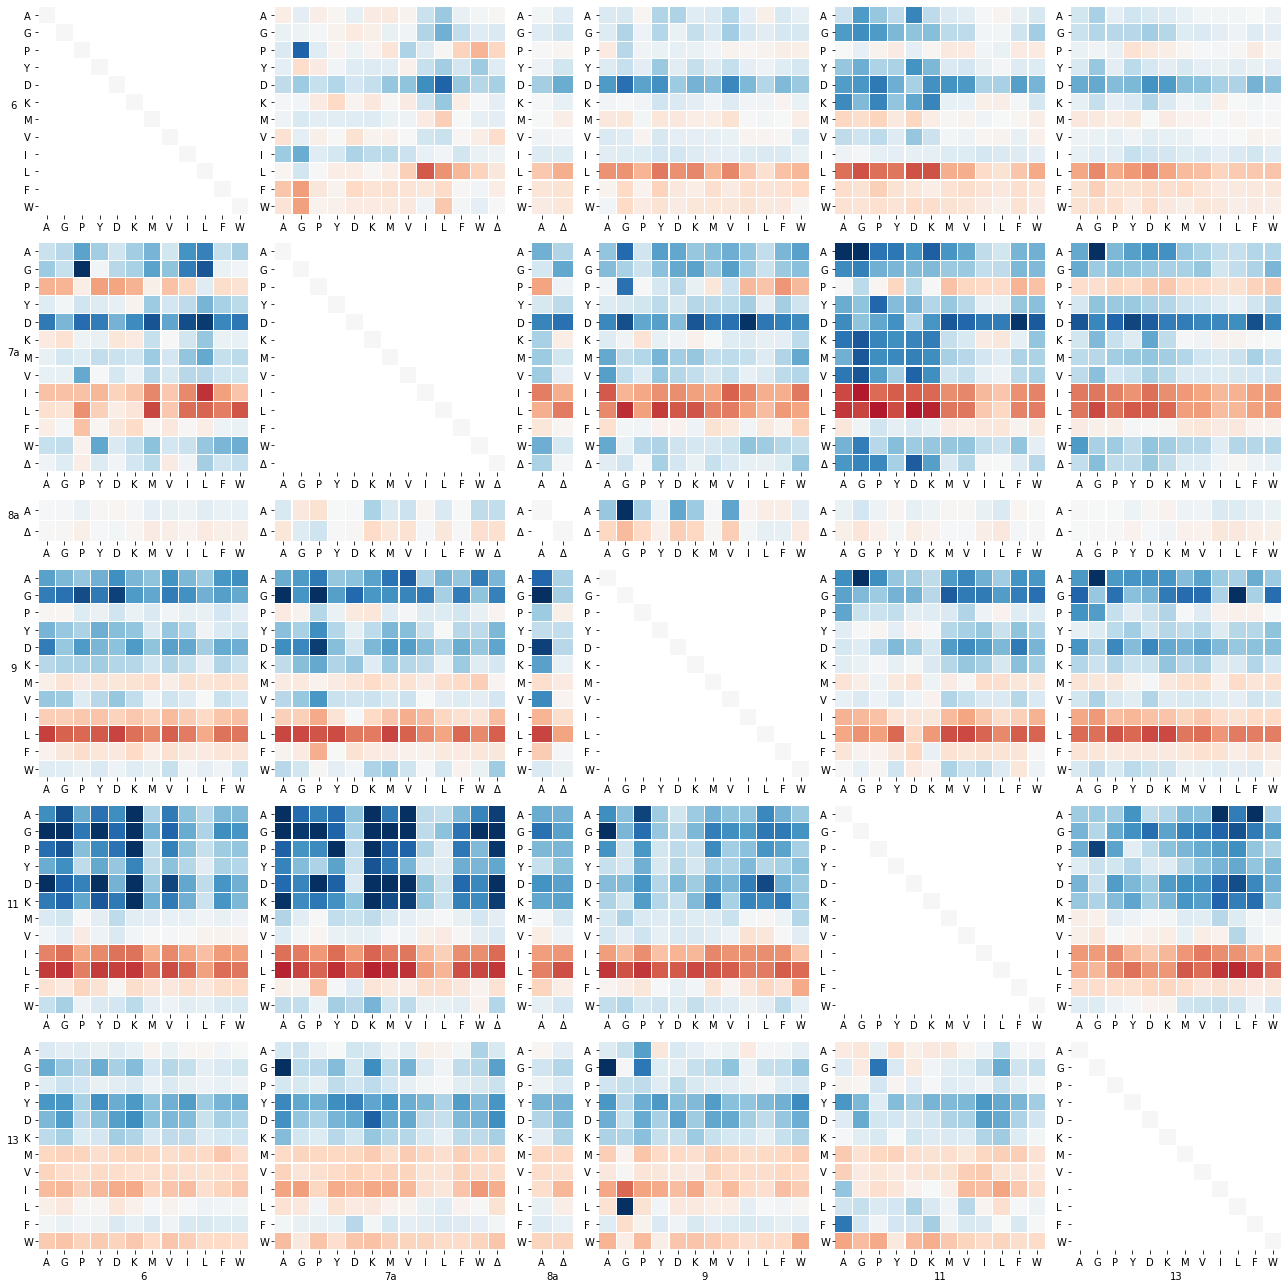

In [26]:
crange=[-3,3]

fig, axes = plt.subplots(6, 6, figsize=(18,18),
                        gridspec_kw={'width_ratios': [2,2.2,0.4,2,2,2],'height_ratios': [2,2.2,0.4,2,2,2]})

# top left axes = axes[0,0]
# top row, middle = axes[0,2]

for a in range(len(valid_pos)): # a = row index, running from 0 to 4
    for b in range(len(valid_pos)): # b = column index, running from 0 to 4
        ax = axes[a][b]
        sns.heatmap(log_col_dfs[valid_pos[a]][valid_pos[b]], vmin=crange[0], vmax=crange[1], linewidths=0.1, ax=ax, 
                    cmap="RdBu_r", cbar=False)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
        ax.tick_params(axis='y', which='major', pad=11)
        # set labels on the outer edges
        if b == 0:
            ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
        if a == 5:
            ax.set_xlabel(valid_pos[b])


plt.tight_layout()
plt.savefig('2D_conditional_heatmap_log2_-3to3.png', dpi=300)
plt.show()

The conditional dependence of amino acid preference between six randomised positions.

## Epistasis

In [27]:
mi_ideal_dfs = {posA : {posB : "" for posB in valid_pos} for posA in valid_pos}
df_1D = df_enr/df_enr.sum()

for posA in valid_pos:
    for posB in valid_pos:
        dict_data = {}
        for aaA in pos_aa[posA]:
            f_a = df_1D[posA][aaA]
            dict_data[aaA] = []
            for aaB in pos_aa[posB]:
                f_b =df_1D[posB][aaB]
                try:
                    dict_data[aaA].append(f_a*f_b)
                except ValueError:
                    dict_data[aaA].append(np.nan)
        mi_ideal_dfs[posA][posB] = pd.DataFrame.from_dict(dict_data, orient='index', columns=pos_aa[posB])

In [28]:
def bottom_epistasis_plot(ax_lims, log_function=np.log10, fname=None):
    
    joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, log_function)

    fig, axes = plt.subplots(5, 5, figsize=(14,13),
                             gridspec_kw={'width_ratios': [2,2.2,0.35,2,2],'height_ratios': [2.2,0.35,2,2,2],
                                         'wspace':0, 'hspace':0})

    mi_lim = [-3, 3]
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        posA = valid_pos[a]
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            posB = valid_pos[b]
            if (b == 5) or (a == 0):
                continue
            elif b >= a:
                axes[a-1][b].axis('off')
                continue
            ax = axes[a-1][b]
            df = (joint_freq_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(log_function)

            # draw heatmap in a box to delineate plots
            sns.heatmap(df, linewidths=0.1, ax=ax, vmin=mi_lim[0], vmax=mi_lim[1], center=0,
                        cmap="RdBu_r", cbar_ax=axes[0][2], 
                        cbar_kws={'label': '', 'extend': 'both', 'ticks': cbar_ticks}) # all colorbars are plotted to the same axes
            # draw a box, hide labels
            for sp in ax.spines.keys():
                ax.spines[sp].set_visible(True)
            # if we don't want any ticks or labels
            ax.tick_params(bottom=False,left=False, labelbottom=False, labelleft=False)

            # turn the labels back on at the outer edges
            if b == 0:
                ax.tick_params(left=True, labelleft=True)
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
                ax.tick_params(axis='y', which='major', pad=11)
            if a == 5:
                ax.tick_params(bottom=True, labelbottom=True)
                ax.set_xlabel(valid_pos[b])

    # colorbar formatting
    axes[0][2].axis('on')

    plt.tight_layout()
    if fname:
        plt.savefig(fname)

    plt.show()

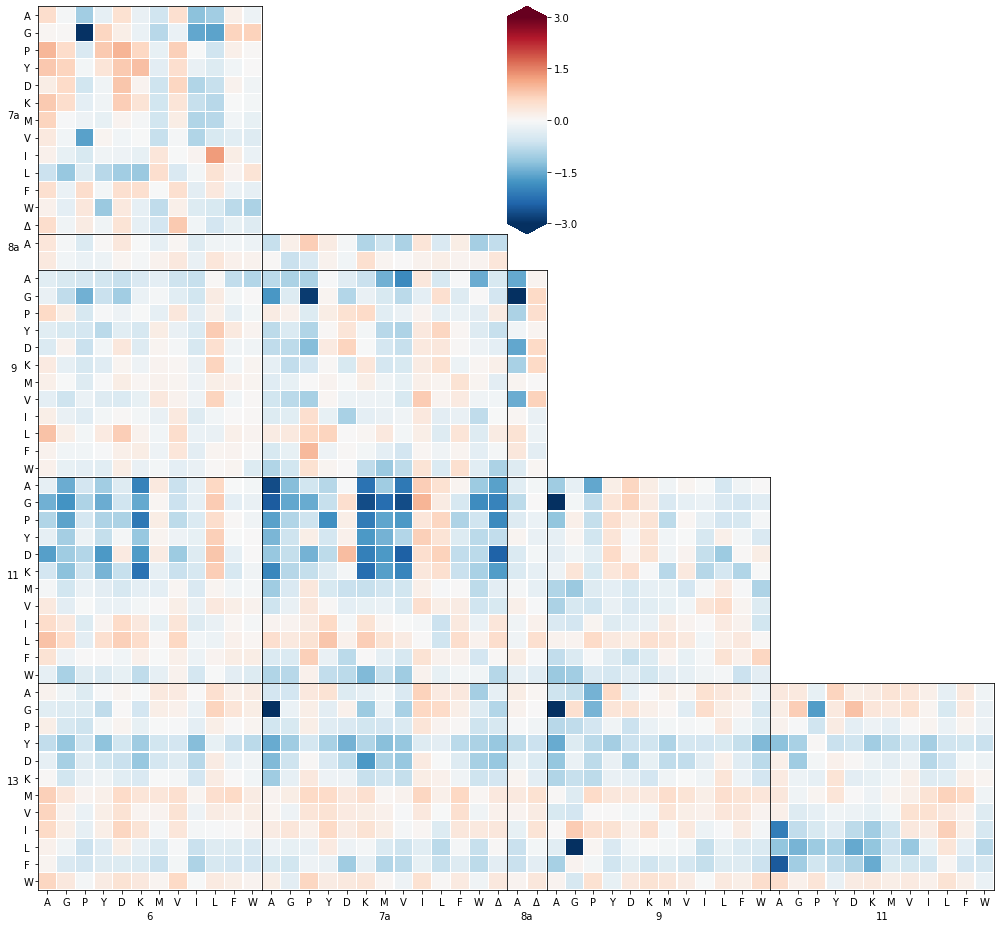

In [29]:
bottom_epistasis_plot((-3, 3), np.log2)

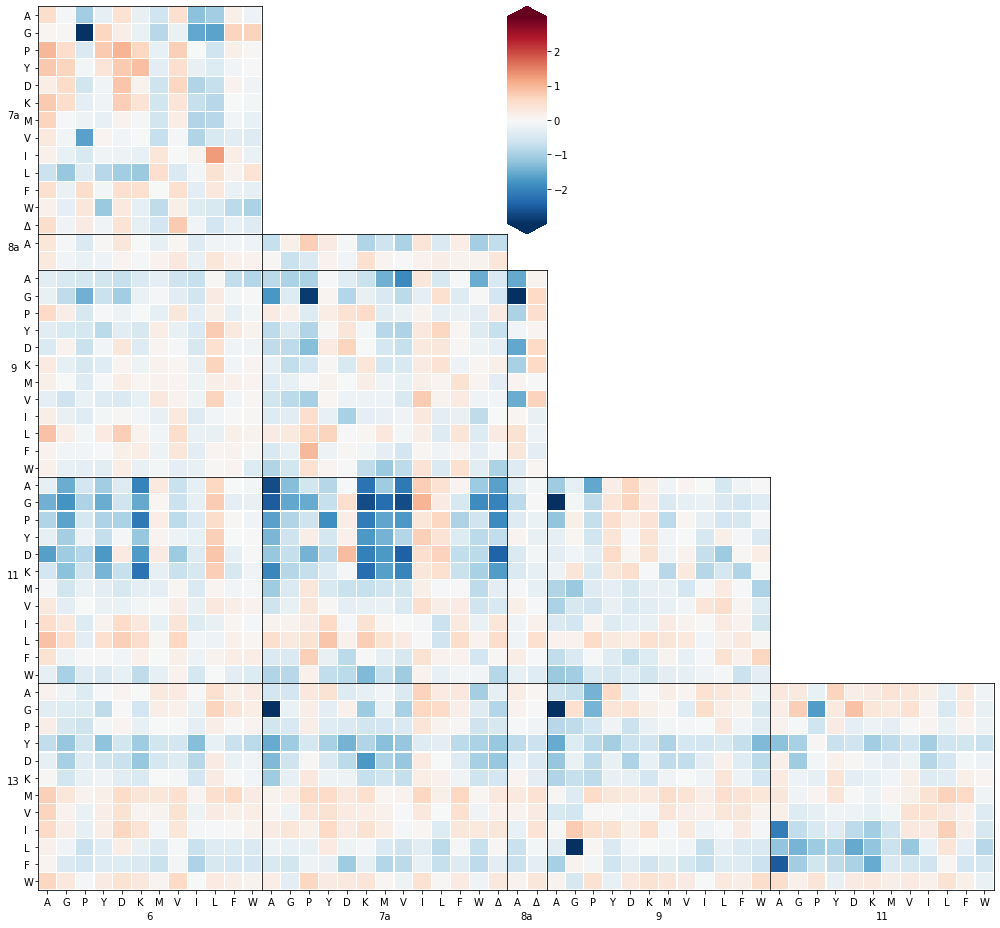

In [30]:
bottom_epistasis_plot((-2, 2), np.log2)

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

## Zoom in on beneficial epistasis

Suggestive of anchorage effects in I/L in positions 7a, 9 and 11, and MVIW in 13.

### Epistasis plots with unequal scales, log2 and minimal annotation

In [31]:
joint_freq_dfs, log_freq_dfs = get_joint_log_dfs(joint_count_dfs, np.log2)

In [32]:
def epistasis_plots(joint_freq_dfs, ax_lims, log_function=np.log10, filt=None, fname=''):
    """
    df_replace: df[df < 0], 
    """

    fig, axes = plt.subplots(5, 5, figsize=(14,13),
                             gridspec_kw={'height_ratios': [2,2.2,0.35,2,2],'width_ratios': [2.1,0.35,2,2,2],
                                          'wspace':0.05, 'hspace':0.05})
    mi_lim = ax_lims
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    for a in range(len(valid_pos)): # a = row index, running from 0 to 4
        posA = valid_pos[a]
        for b in range(len(valid_pos)): # b = column index, running from 0 to 4
            posB = valid_pos[b]
            if (b == 0) or (a == 5):
                continue
            elif b <= a:
                axes[a][b-1].axis('off')
                continue
            ax = axes[a][b-1]
            df = (joint_freq_dfs[posA][posB]/mi_ideal_dfs[posA][posB]).apply(log_function)

            if filt == 'Positive':
                df[df < 0] = np.nan
            elif filt == 'Negative':
                df[df > 0] = np.nan

            sns.heatmap(df, linewidths=0.1, ax=ax, vmin=mi_lim[0], vmax=mi_lim[1], center=0,
                        cmap="RdBu_r",  cbar_ax=axes[2][0],
                        # all colorbars are plotted to the same axes
                        cbar_kws={'ticks': cbar_ticks, 'label': '', 'extend': 'both', 'orientation':'horizontal'})

            for sp in ax.spines.keys():
                ax.spines[sp].set_visible(True)
            
            # if we don't want any ticks or labels
            ax.tick_params(bottom=False,left=False, labelbottom=False, labelleft=False)
            
            # ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')
            # ax.tick_params(axis='y', which='major', pad=11)
            
            # set labels on the outer edges
            if a == (b-1):
                ax.set_ylabel(valid_pos[a], rotation=0, labelpad=10)
                ax.set_xlabel(valid_pos[b])

    # colorbar formatting
    axes[2][0].axis('on')

    #plt.tight_layout()
    plt.savefig(fname, transparent=True)

    plt.show()

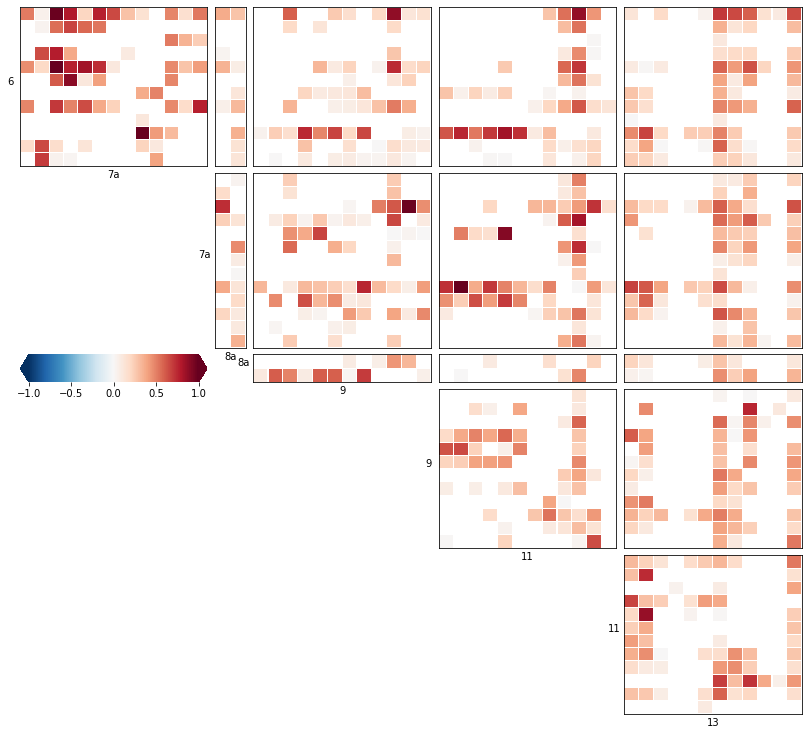

In [33]:
epistasis_plots(joint_freq_dfs, (-1, 1), log_function=np.log2, filt='Positive', fname='Epistasis_top_log2_-1to1_pos.svg')

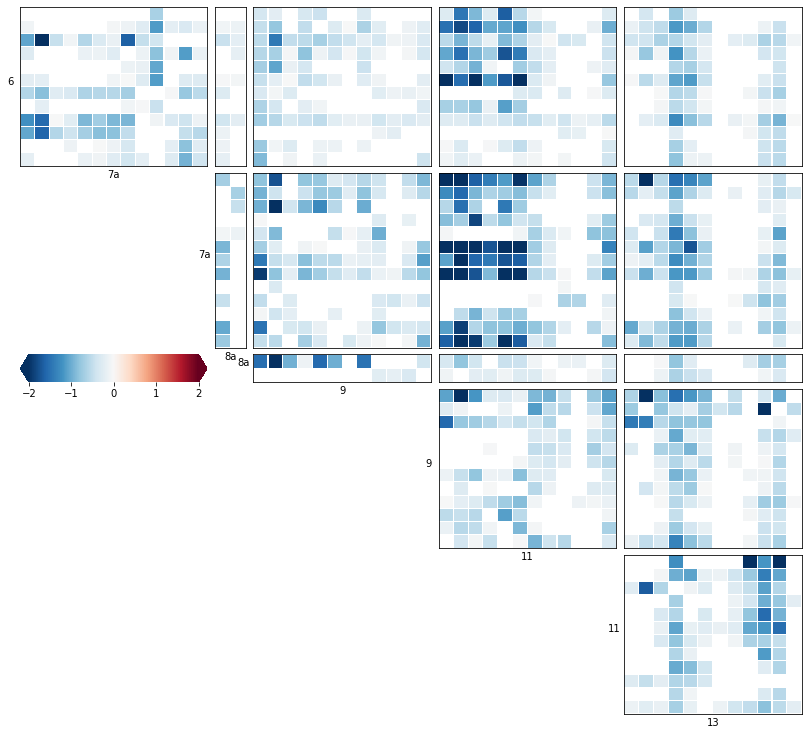

In [34]:
epistasis_plots(joint_freq_dfs, (-2, 2), log_function=np.log2, filt='Negative', fname='Epistasis_top_log2_-2to2_neg.svg')

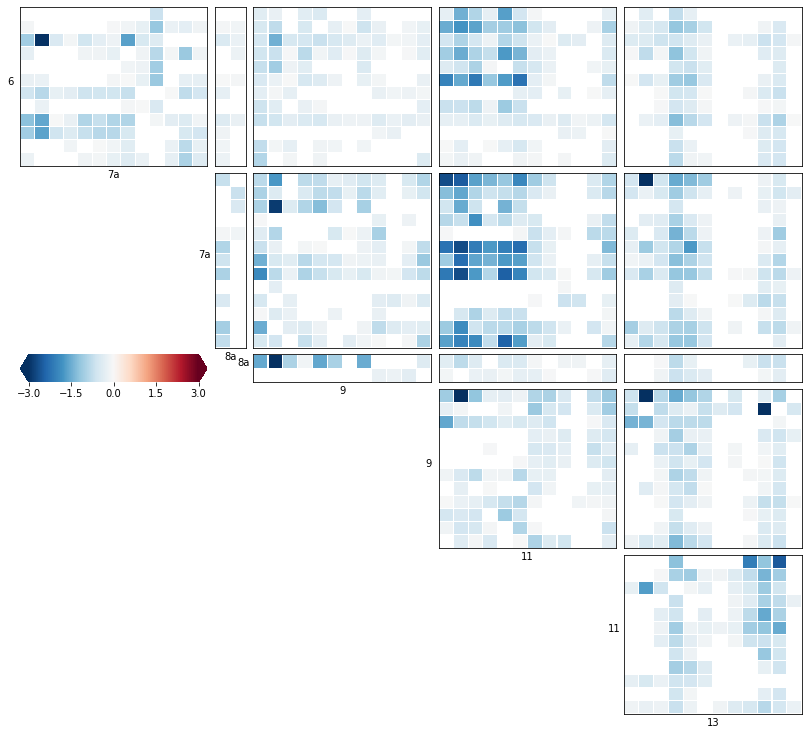

In [35]:
epistasis_plots(joint_freq_dfs, (-3, 3), log_function=np.log2, filt='Negative', fname='Epistasis_top_log2_-3to3_neg.svg')

## Zooming in on the I/L substitutions and the effect of insertions

In [36]:
pos_order = ['6', '7a', '8a', '9', '11',  '13']

hydrophobics = {'6': ['P', 'M','L', 'F', 'V'],
                 '7a': ['I', 'L', 'P'],
                  '9': ['I', 'L', 'F', 'M'],
                 '11':['I','L', 'F'],
                 '13': ['M', 'V', 'I', 'F', 'L', 'W']}

i_l = {'6': ['P', 'M','L', 'F', 'V'],
        '7a': ['I', 'L', 'P'],
       '8a': ['A'],
        '9': ['I', 'L'],
        '11':['I','L'],
        '13': ['I', 'L']}

In [37]:
hpho_1 = []
for k1 in pos_order:
    try:
        hpho_1.append({k1 : hydrophobics[k1]})
    except KeyError:
        pass

In [38]:
il_1 = []
for k1 in pos_order:
    try:
        il_1.append({k1 : i_l[k1]})
    except KeyError:
        pass

In [39]:
def find_non_pref_aa(r1):
    r2 = []
    for combo in r1:
        allowed = {}
        for pos, good_aa in combo.items():
            bad_aa = [aa for aa in pos_aa[pos] if not aa in good_aa]
            allowed[pos] = bad_aa
        r2.append(allowed)

    pos = df_pos.to_dict()
    return r2

In [40]:
def restricted_preference_plots(ax_lims, log_function, rest, fname='', fsize=(12,6)):
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    fig, axes = plt.subplots(2, len(rest) +1,  figsize=fsize,
                            gridspec_kw={'wspace':0.3, 'hspace':0.3})
    rest2 = find_non_pref_aa(rest)
    # add the 1D unrestricted plot
    log_enr = (df_enr/(df_enr.sum()/df_enr.astype(bool).sum())).apply(log_function)   
    sns.heatmap(log_enr, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.1, ax=axes[0][0], cmap="RdBu_r", 
                cbar=False)
    axes[0][0].set_title('All')
    axes[1][0].axis('off')

    for i in range(1,len(rest)+1):
        r = i-1
        
        # top plot: normalise the df relative to even library
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[r], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r", cbar=False)
        axes[0][i].set_title(', '.join(rest[r].keys()))

        # bottom plot: what happens with the inverse sequence restriction
        cnts = single_fraction_enrichment(pos, 'high', 1, rest2[r], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r", cbar=False)
    
    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


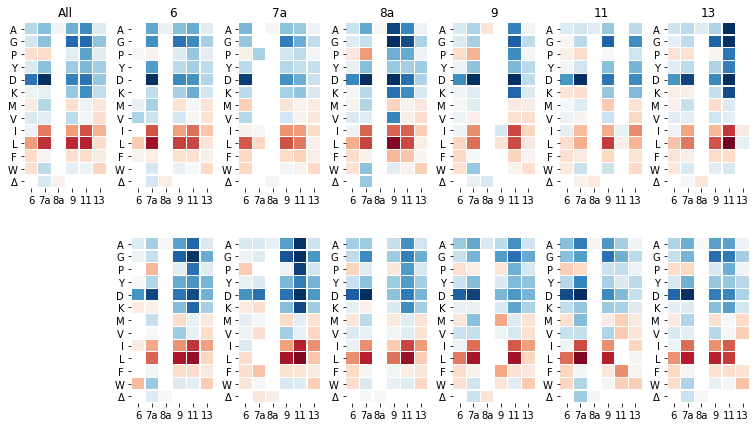

In [41]:
restricted_preference_plots((-2, 2), np.log2, il_1, 'S12_one_res_log2_-2to2.svg', (13,7))

#### Relative single motif change in distribution

In [42]:
def restricted_preference_change_plots(ax_lims, log_function, rest, fname='', fsize=(10,6)):

    fig, axes = plt.subplots(2, len(rest),  figsize=fsize)
    rest2 = find_non_pref_aa(rest)
    
    for i in range(len(rest)):
        # top plot: with hydrophobic residues
        cnts = single_fraction_enrichment(pos, 'high', 1, rest[i], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log2)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][i], cmap="RdBu_r",  cbar=False)
        axes[0][i].set_title(', '.join(rest[i].keys()))

        # bottom  plot: normalise the df relative to df_enr (unrestricted)
        
        cnts = single_fraction_enrichment(pos, 'high', 1, rest2[i], proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_order)
        top_df = df_restrict/df_restrict.sum()
        mask = df_restrict.astype(bool)
        b_df = df_enr.where(mask)/ df_enr.where(mask).sum()
        log_df = (top_df/b_df).apply(np.log2)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[1][i], cmap="RdBu_r",  cbar=False)


    for ax in axes.flat:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    if fname:
        plt.savefig(fname)
    plt.show()

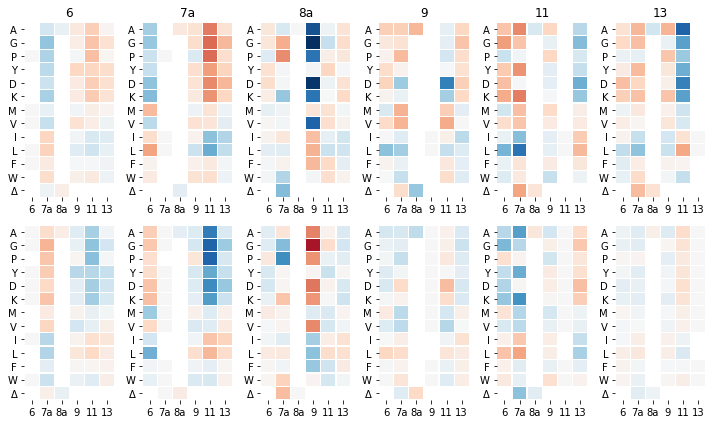

In [43]:
restricted_preference_change_plots((-1, 1), np.log2, il_1, 'S13_one_res_relative_log2_-1to1.svg', (10,6))

Moving a single fixed hydrophobic Leu/Ile residue across the D-domain?
- 6: sets a mild preference for a hydrophobic in 7a and a mild relaxation towards the end of D-domain, but the change is very minor.
- 7a: a fairly strong efect that fixes 6Leu/Met, has little effect on 9 (that is, a strong preference of I/L remains, but 11 greatly relaxes towards non-hydrophobics.
- 9: few changes to overall sequence preference, keeping a preference for hydrophobics in 7a and 11. However, without Leu/Ile at 9, the preferences look mostly unchanged, because other hydrophobic residues can take their place in the middle of the motif.
- 11: 9 keeps the usual preference of Leu/Ile, 13 is shifted towards hydrophobics, while 6 and 7a relax. If there is no Leu/Ile here, then the D-domain hydrophobic sequence shifts towards 6 and 7a.
- 13: some strengthening of preference for 11, 9 remains.

Taken together, this suggests the presence of a core hydrophobic motif in three consecutive randomised positions: 6/7a/9, 7a/9/11 or 9/11/13.

### Consecutive two-residue motifs

In [44]:
aa_pairs = [['6', '7a'], ['7a', '8a'], ['8a', '9'],['7a', '9'], ['9', '11'], ['11', '13']]

il_2 = [{k: i_l[k] for k in p} for p in aa_pairs]

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


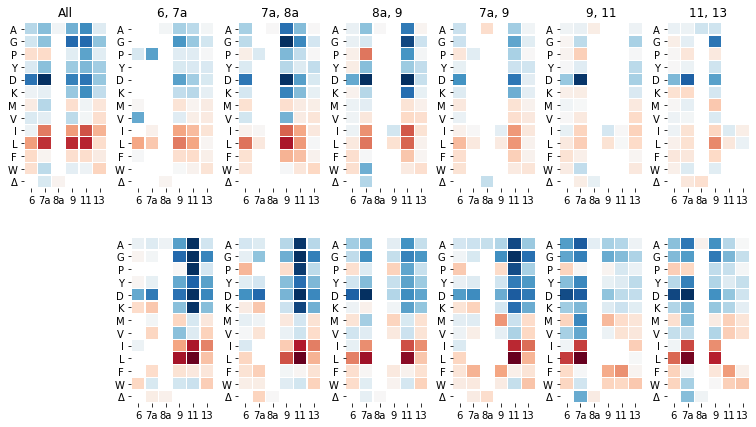

In [45]:
restricted_preference_plots((-2, 2), np.log2, il_2, 'S14_PhiXPhi_log2_-2to2.svg', (13,7))

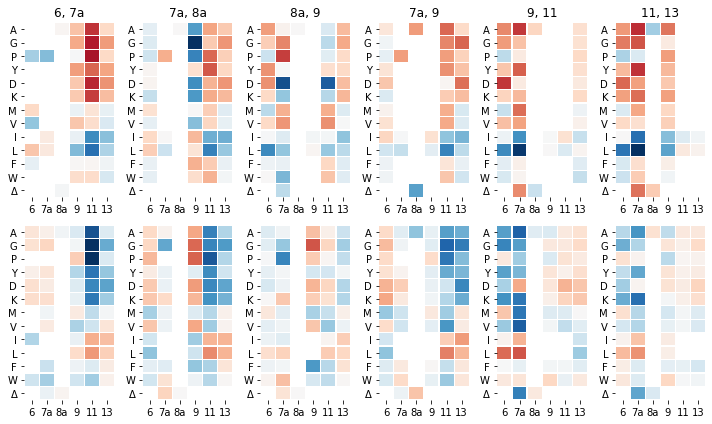

In [46]:
restricted_preference_change_plots((-1, 1), np.log2, il_2,'S15_PhiXPhi_relative_log2_-1to1.svg', (10,6))

### Non-consecutive two-residue motifs: ΦXXXΦ

In [47]:
nc_aa_pairs = [['6', '8a'], ['6', '9'], ['7a', '11'], ['9', '13']]

il_3 = [{k: i_l[k] for k in p} for p in nc_aa_pairs]

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


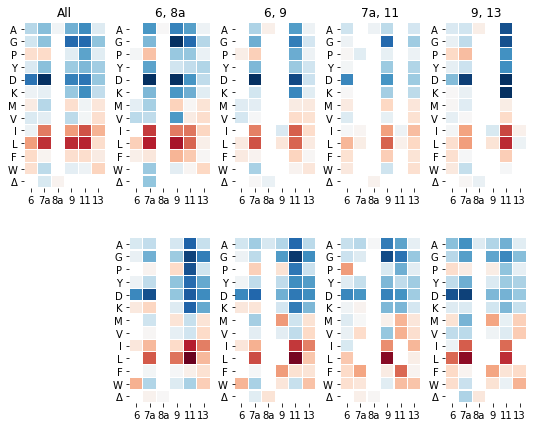

In [48]:
restricted_preference_plots((-2, 2), np.log2, il_3, 'S16_PhiXXXPhi_log2_-2to2.svg', fsize=(9,7))

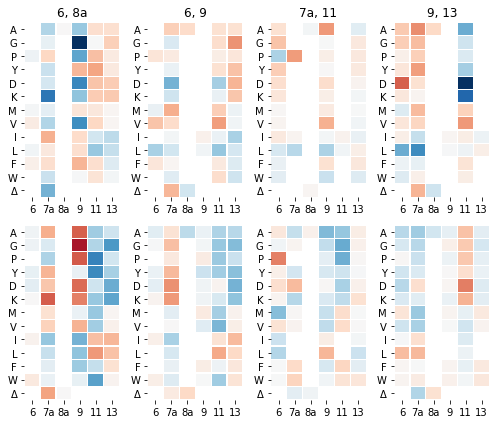

In [49]:
restricted_preference_change_plots((-1, 1), np.log2, il_3,'S17_PhiXXXPhi_relative_log2_-1to1.svg', fsize=(7,6))